## Requirement 1: Stochatic Environment
**Build a stochastic environment including**
- **A distribution over the bids of the other agents**
- A function specifying the probability with which an user buys for every price


Pricing algorithm: Build a pricing strategy using the continuous set of prices p ∈ [0, 1] and Gaussian Processes.\
**Bidding algorithm: Consider a sequence of second-price auctions. Build two learning algorithms to deal with the bidding problem:**
- primal-dual algorithm for truthful auctions
- UCB-like algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt

c:\Users\39327\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\39327\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\39327\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Second price auctions

In [2]:
class SecondPriceAuction:
    def __init__(self, ctrs):
        # ctr = click though rate = lambda * q
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        # sort not by bids, but estimated values
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]
        payment = values[second]/self.ctrs[winners]
        return payment.round(2)
    
    def round(self, bids):
        # given bids, return winner(s) and the estimated values (product of 3 terms : lambda, q, bid) of winner(s)
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

### Bidding Environment

In [3]:
class UniformBiddingEnvironment:
    def __init__(self, T, n_advertisers, auction):
        self.T = T
        self.auction = auction
        self.n_advertisers = n_advertisers
        np.random.seed(42)
        self.other_bids = np.random.uniform(0, 1, size = (n_advertisers, T))
        self.m_t = self.other_bids.max(axis=0)

    def round(self, round, bid):
        bids_at_round = np.append(self.other_bids[:, round], bid)
        winners, payments_per_click = self.auction.round(bids=bids_at_round)
        return winners, self.m_t[round]
    
    def get_clairvoyant_truthful(self, B, my_valuation):
        ## I compute my sequence of utilities at every round
        utility = (my_valuation-self.m_t)*(my_valuation>=self.m_t)
        #   if valuation less than max_bid of the round, no need to participate
        #   if higher, utility is the difference

        ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
        ## In second price auctions, I can find the sequence **greedily**:
        sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
        clairvoyant_utilities = np.zeros(self.T)
        clairvoyant_bids= np.zeros(self.T)
        clairvoyant_payments = np.zeros(self.T)
        c = 0
        i = 0
        #    (enough budget) and (examined all rounds)
        while c <= B-1 and i < self.T:
            clairvoyant_bids[sorted_round_utility[i]] = 1  # simply bid 1 because we are in second-price auction
            clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
            clairvoyant_payments[sorted_round_utility[i]] = self.m_t[sorted_round_utility[i]]
            c += self.m_t[sorted_round_utility[i]]  # cost is incremented by second price of that round
            i+=1
        return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

### Bidding Agents

#### Primal-dual algorithm -> Multiplicative Pacing

In [4]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta # learning rate
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)
    
    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

#### UCB-like algorithm -> simple UCB

In [35]:
class UCBAgent:
    def __init__(self, valuation, budget, T, K=None, range=1):
        self.T = T
        self.valuation = valuation
        self.budget = budget
        if K is None:
            # prescribed by theory
            epsilon = T**(-0.33)
            K = int(1/epsilon)
        self.K = K
        self.range = range
        self.arms = np.linspace(0, valuation, K)
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.a_t = None
        self.t = 0

    def bid(self):
        # if budget depleted
        if self.budget < 1:
            return 0
        
        # play every arm at least once
        if self.t < self.K:
            self.a_t = self.t
        else:
            # compute UCB for every arms, choose arm with highest UCB
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.t)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
            # if(self.t<50):
            #     print(f'round {self.t} : {ucbs}\n bidded {self.arms[self.a_t]} with ucb={ucbs[self.a_t]}')
        return self.arms[self.a_t]

    def update(self, f_t, c_t):
        self.t += 1
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (f_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.budget -= c_t

#### UCB-like algorithm -> UCB with negative feedback when not winning (lost opportunity)
lost opportunity computed as average utility when winning

In [36]:
class UCBNFAgent:
    def __init__(self, valuation, budget, T, K=None, range=1):
        self.T = T
        self.valuation = valuation
        self.budget = budget
        if K is None:
            # prescribed by theory
            epsilon = T**(-0.33)
            K = int(1/epsilon)
        self.K = K
        self.range = range
        self.arms = np.linspace(0, valuation, K)
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.winning_total_reward = 0
        self.won_time = 0
        self.a_t = None
        self.t = 0

    def bid(self):
        # if budget depleted
        if self.budget < 1:
            return 0
        
        # play every arm at least once
        if self.t < self.K:
            self.a_t = self.t
        else:
            # compute UCB for every arms, choose arm with highest UCB
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
            # if(self.t<50):
            #     print(f'round {self.t} : {ucbs}\n bidded {self.arms[self.a_t]} with ucb={ucbs[self.a_t]}')
        return self.arms[self.a_t]

    def update(self, f_t, c_t):
        self.N_pulls[self.a_t] += 1
        
        if(f_t>0):
            self.won_time += 1
            self.winning_total_reward += f_t
        elif(self.t >= self.K):
            f_t = - (self.winning_total_reward / self.won_time)
    
        self.average_rewards[self.a_t] += (f_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.budget -= c_t
        self.t += 1

### Simulation

In [37]:
# environmental settings
n_users = 10000
n_competitors = 3
ctrs = np.ones(n_competitors+1)
my_valuation = 0.8
B = 5000
auction = SecondPriceAuction(ctrs)

env = UniformBiddingEnvironment(n_users, n_competitors, auction)

clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = env.get_clairvoyant_truthful(B, my_valuation)

eta = 1/np.sqrt(n_users) # from theory
agentMP = MultiplicativePacingAgent(valuation=my_valuation,
                                  budget=B,
                                  T=n_users, 
                                  eta=eta)

agentUCB = UCBAgent(my_valuation, B, n_users, range=1)
agentNF = UCBNFAgent(my_valuation, B, n_users, range=0.5)
agentNF1 = UCBNFAgent(my_valuation, B, n_users, range=0.1)
# range works as the hyperparameter in this problem

agents = {
    "Multiplicative Pacing": agentMP,
    "Plain UCB": agentUCB,
    "UCB with negative feedback": agentNF,
    "UCBNF with range 0.1" : agentNF1
}


utilities = np.zeros((len(agents), n_users))
my_bids = np.zeros((len(agents), n_users))
my_payments = np.zeros((len(agents), n_users))
total_wins = np.zeros((len(agents)))

np.random.seed(18)
for u in range(n_users):
    # interaction
    for idx, (name, agent) in enumerate(agents.items()):
        my_bid = agent.bid()
        winners, m_t = env.round(u, my_bid)
        my_win = int(winners==n_competitors)
        f_t, c_t = (my_valuation-m_t)*my_win, m_t*my_win
        agent.update(f_t, c_t)
        utilities[idx,u] = f_t
        my_bids[idx,u] = my_bid
        my_payments[idx,u] = c_t
        total_wins[idx] += my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: [5028. 2020. 4204. 5055.]


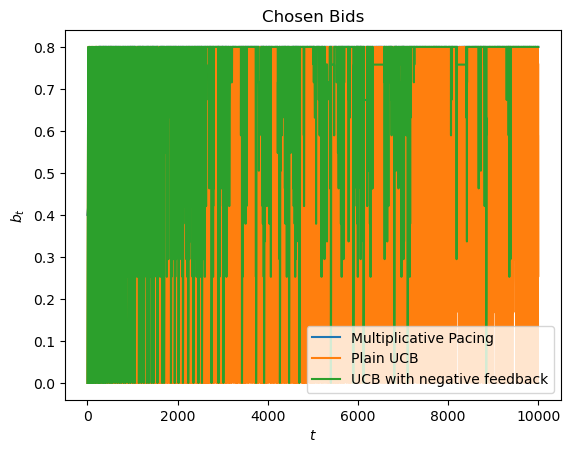

In [32]:
plt.plot(my_bids[0])
for i, name in enumerate(agents):
    plt.plot(my_bids[i], label=name)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

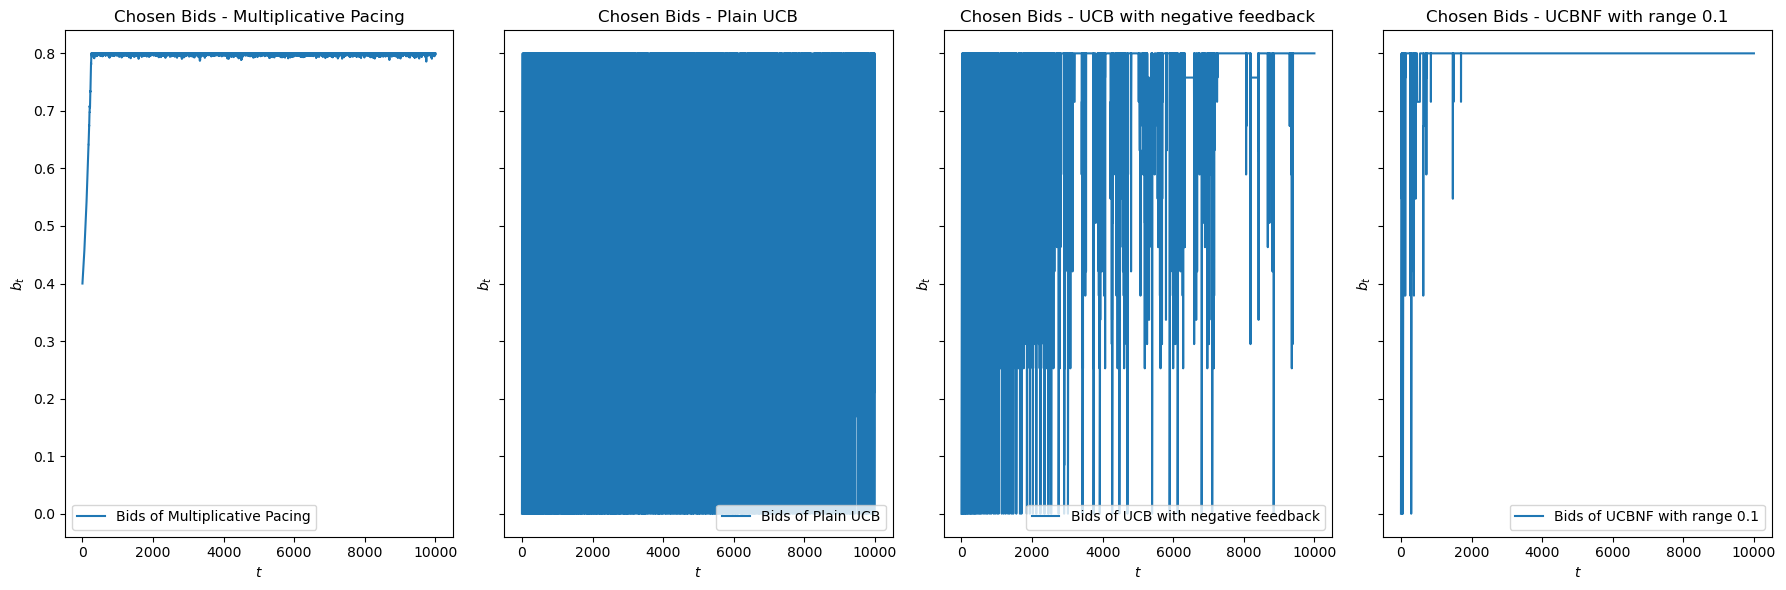

In [38]:
# Plot cumulative regret for each agent in subplots
fig, axs = plt.subplots(1, len(agents), figsize=(18, 6), sharey=True)

for i, (name, agent) in enumerate(agents.items()):
    axs[i].plot(my_bids[i], label=f'Bids of {name}')
    axs[i].set_xlabel('$t$')
    axs[i].set_ylabel('$b_t$')
    axs[i].set_title(f'Chosen Bids - {name}')
    axs[i].legend()

plt.tight_layout()
plt.show()

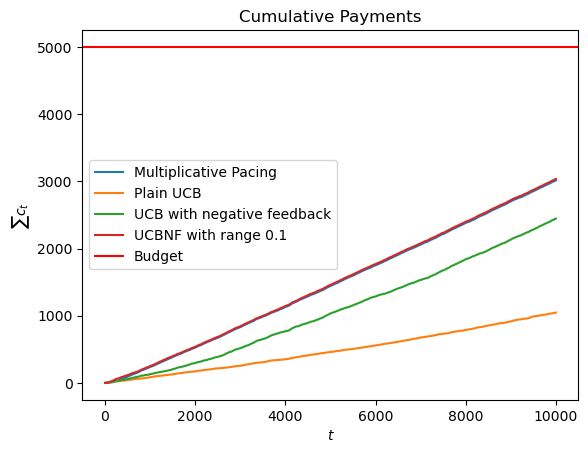

In [39]:
for i, name in enumerate(agents):
    cumulative_payments = np.cumsum(my_payments[i])
    plt.plot(cumulative_payments, label=name)
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.title('Cumulative Payments')
plt.show()

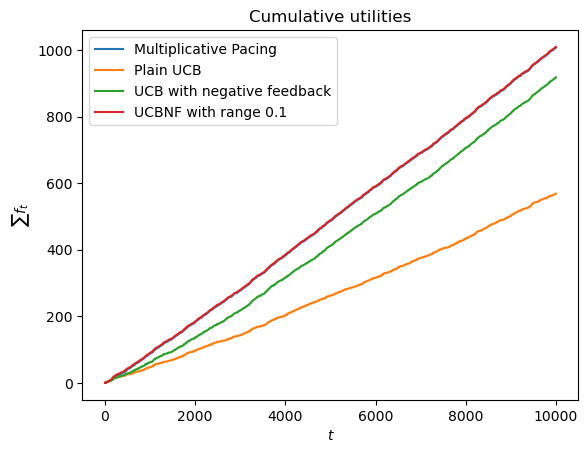

In [40]:
for i, name in enumerate(agents):
    cumulative_utilities = np.cumsum(utilities[i])
    plt.plot(cumulative_utilities, label=name)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative utilities')
plt.show()

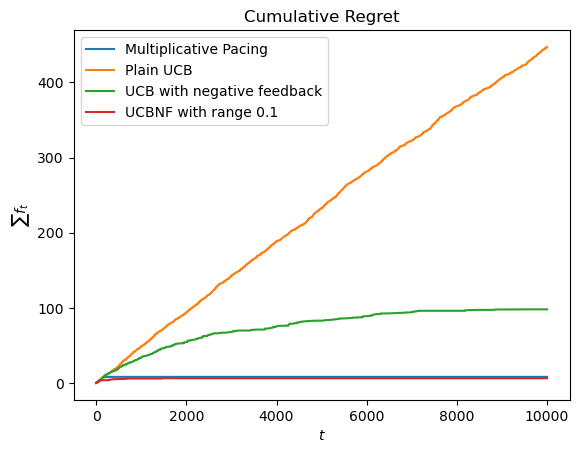

In [41]:
for i, name in enumerate(agents):
    cumulative_regret = np.cumsum(clairvoyant_utilities - utilities[i])
    plt.plot(cumulative_regret, label=name)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret')
plt.show()